# LEGO Data Analysis — Polished Project
<div style="text-align:center">
  <img src="https://i.imgur.com/49FNOHj.jpg" width="600" alt="LEGO bricks">
</div>

**Author:** Prakash Saud  
**Goal:** Explore LEGO datasets (colors, sets, themes) to tell a clear data story: what exists in the catalogue, how LEGO evolved over time, which themes dominate, and whether sets grew more complex.

**What this notebook does (high-level):**
1. Load & validate datasets.
2. Inspect colours (unique colours, transparency).
3. Explore sets (first year, largest sets, sets/year).
4. Examine themes (which themes are largest, Star Wars deep-dive).
5. Visualize trends (line charts, scatter plots, dual-axis).
6. Produce insights and next steps.

## Table of Contents
1. Data & Setup
2. Colours dataset — counts & transparency
3. Sets dataset — history & largest sets
4. Time series — sets per year & themes per year
5. Complexity — average parts per set
6. Themes — merge & top themes (bar chart)
7. Star Wars deep dive
8. Summary, insights & next steps

## Important: File paths & how to run
Place the provided `data/` folder next to this notebook, so files are available as:
- `data/colors.csv`
- `data/sets.csv`
- `data/themes.csv`

If your files are in `/mnt/data/...` (Colab or some environments), adjust `pd.read_csv()` paths accordingly. The next code cell checks for files and helps you adapt.

## Imports & file check

### Why this cell?
We import standard packages used throughout the analysis:
- **pandas** for data manipulation
- **matplotlib** for plotting

We also check the `data/` folder so you can confirm the expected CSV files are available. If files are missing, update paths before proceeding.

In [1]:
# Code cell: imports and quick file check
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# show plots inline (in notebook) and improve default figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Look for a 'data' folder or list csv files in the working directory
if os.path.isdir('data'):
    print("Files in data/:", os.listdir('data')[:50])
else:
    # fallback: list CSVs in current directory (helpful if path differs)
    csvs = [f for f in os.listdir('.') if f.endswith('.csv')]
    print("No 'data/' folder found. CSVs in current dir:", csvs)

Files in data/: ['.DS_Store', 'colors.csv', 'sets.csv', 'themes.csv']


## Load the CSVs

### Why load these files?
- `colors.csv` — contains color names, rgb values and whether color is transparent/opaque.
- `sets.csv` — metadata for LEGO sets: `set_num`, `name`, `year`, `theme_id`, `num_parts`, etc.
- `themes.csv` — mapping of `id` (primary key) to human-readable theme `name`.

Next we'll explore the **colors** dataset to answer: *how many unique colours exist and how many are transparent?*

In [2]:
# Load datasets — adjust paths if your CSVs are elsewhere.
colors = pd.read_csv('data/colors.csv')
sets = pd.read_csv('data/sets.csv')
themes = pd.read_csv('data/themes.csv')

# Quick peek of each dataset
print("=== colors.csv ===")
display(colors.head())
print("\n=== sets.csv ===")
display(sets.head())
print("\n=== themes.csv ===")
display(themes.head())

=== colors.csv ===


,id,name,rgb,is_trans
0,-1,Unknown,0033B2,f
1,0,Black,05131D,f
2,1,Blue,0055BF,f
3,2,Green,237841,f
4,3,Dark Turquoise,008F9B,f



=== sets.csv ===


,set_num,name,year,theme_id,num_parts
0,001-1,Gears,1965,1,43
1,0011-2,Town Mini-Figures,1978,84,12
2,0011-3,Castle 2 for 1 Bonus Offer,1987,199,0
3,0012-1,Space Mini-Figures,1979,143,12
4,0013-1,Space Mini-Figures,1979,143,12



=== themes.csv ===


,id,name,parent_id
0,1,Technic,NaN
1,2,Arctic Technic,1.0
2,3,Competition,1.0
3,4,Expert Builder,1.0
4,5,Model,1.0


## Explore colours dataset

### Colours: Unique count & transparency

**Objectives:**
- Find total number of _unique_ LEGO colours.
- Compare transparent vs opaque counts.
- Show two different ways to compute transparency counts (illustrates multiple pandas approaches).

**Why:** This small example demonstrates basic data cleaning and aggregation operations that generalize to larger analyses.

In [4]:
# Ensure the column names match expected names (inspect)
print("Columns in colors:", colors.columns.tolist())

# Count unique names with .nunique()
unique_colour_count = colors['name'].nunique()
print(f"Total unique LEGO colours: {unique_colour_count}")

# Show a selection of colours to sanity-check
display(colors[['id', 'name', 'rgb', 'is_trans']].head(10))

Columns in colors: ['id', 'name', 'rgb', 'is_trans']
Total unique LEGO colours: 135


,id,name,rgb,is_trans
0,-1,Unknown,0033B2,f
1,0,Black,05131D,f
2,1,Blue,0055BF,f
3,2,Green,237841,f
4,3,Dark Turquoise,008F9B,f
5,4,Red,C91A09,f
6,5,Dark Pink,C870A0,f
7,6,Brown,583927,f
8,7,Light Gray,9BA19D,f
9,8,Dark Gray,6D6E5C,f


### Two ways to compute transparent vs opaque counts

**Method A:** `.value_counts()` — quick and readable for categorical counts.  
**Method B:** boolean filtering and `.sum()` — explicit and easy to expand into conditional logic (e.g., count `is_trans == 1` or `True`).

We'll compute both so you can see both idioms.

In [5]:
# Method A: value_counts
print("Method A - value_counts():")
try:
    print(colors['is_trans'].value_counts())
except Exception as e:
    print("value_counts failed:", e)

# Method B: boolean sum (handles booleans or 0/1 integers)
print("\nMethod B - boolean filtering:")
# First coerce possible string booleans like 't'/'f' to standard booleans if necessary
# But here we assume is_trans is numeric or boolean; we'll handle multiple formats conservatively
col = colors['is_trans']

# Create boolean mask: treat 1, '1', True as transparent. More robust checks:
transparent_mask = (col == 1) | (col == '1') | (col == True) | (col == 'True') | (col == 'true')
num_transparent = transparent_mask.sum()
num_total = len(colors)
num_opaque = num_total - num_transparent

print(f"Transparent: {num_transparent}")
print(f"Opaque: {num_opaque}")
print(f"Total rows: {num_total}")

Method A - value_counts():
is_trans
f    107
t     28
Name: count, dtype: int64

Method B - boolean filtering:
Transparent: 0
Opaque: 135
Total rows: 135


### What to look for / interpretation
- The `name` column's `.nunique()` counts unique colour *names* — duplicate names would indicate duplicates in the dataset.
- `is_trans` tells us how many colours are transparent. This could matter for visualization and for product descriptions.
- If results look odd (e.g., more transparent than expected) — consider duplicates, nulls, or multiple naming conventions. You may want to `drop_duplicates()` based on RGB or name if duplicates are present.

## Exploring sets.csv
### Explore the sets dataset
**Objectives:**
- See earliest year LEGO sets were released (first year) and list the sets from that year.
- How many distinct products were sold in LEGO's first year?
- Find the top sets by part-count (largest sets).

**Why:** This helps us understand LEGO's history, growth and what 'complex' meant historically vs now.

In [7]:
# Inspect structure and types
print("sets.csv shape:", sets.shape)
display(sets.info())
display(sets.describe(include='all').T)

# Look at important columns
display(sets[['set_num', 'name', 'year', 'num_parts']].head(10))

sets.csv shape: (15710, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15710 entries, 0 to 15709
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   set_num    15710 non-null  object
 1   name       15710 non-null  object
 2   year       15710 non-null  int64 
 3   theme_id   15710 non-null  int64 
 4   num_parts  15710 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 613.8+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
set_num,15710,15710,001-1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,15710,13437,Basic Building Set,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,15710.0,NaN,NaN,NaN,2004.532718,13.994785,1949.0,1998.0,2009.0,2015.0,2021.0
theme_id,15710.0,NaN,NaN,NaN,387.167664,201.27025,1.0,206.0,443.0,524.0,709.0
num_parts,15710.0,NaN,NaN,NaN,166.036346,369.689195,0.0,9.0,45.0,165.0,9987.0


,set_num,name,year,num_parts
0,001-1,Gears,1965,43
1,0011-2,Town Mini-Figures,1978,12
2,0011-3,Castle 2 for 1 Bonus Offer,1987,0
3,0012-1,Space Mini-Figures,1979,12
4,0013-1,Space Mini-Figures,1979,12
5,0014-1,Space Mini-Figures,1979,12
6,0015-1,Space Mini-Figures,1979,18
7,0016-1,Castle Mini Figures,1978,15
8,002-1,4.5V Samsonite Gears Motor Set,1965,3
9,003-1,Master Mechanic Set,1966,403


## Finding first year & sets that year

### Which year were the first LEGO sets released, and what were those sets?
We will:
1. Find the minimum year in `sets['year']`.
2. Filter the DataFrame for that year and list set names and counts.

**Why:** Locates the dataset origin to anchor historical comparisons.

In [9]:
# Convert 'year' to numeric just in case of stray text or NaNs
sets['year'] = pd.to_numeric(sets['year'], errors='coerce')

# Minimum year available in the dataset
min_year = int(sets['year'].min())
print(f"First year in dataset: {min_year}")

# Sets released in the first year and count
first_year_sets = sets[sets['year'] == min_year]
print(f"Number of distinct products in {min_year}: {first_year_sets['set_num'].nunique()}")
display(first_year_sets[['set_num', 'name', 'num_parts']])

First year in dataset: 1949
Number of distinct products in 1949: 5


,set_num,name,num_parts
9521,700.1-1,Extra-Large Gift Set (ABB),142
9534,700.2-1,Large Gift Set (ABB),178
9539,700.3-1,Medium Gift Set (ABB),142
9544,700.A-1,Small Brick Set (ABB),24
9545,700.B-1,Small Doors and Windows Set (ABB),12


### Which LEGO sets have the most parts?
We:
- Clean `num_parts` to numeric.
- Sort descending to find largest sets.
- Consider missing `num_parts` values (we treat them as NaN and exclude when sorting).

In [10]:
# Clean num_parts to numeric
sets['num_parts'] = pd.to_numeric(sets['num_parts'], errors='coerce')

# Show top 10 largest sets by number of parts
largest_sets = sets.sort_values('num_parts', ascending=False).dropna(subset=['num_parts'])
display(largest_sets[['set_num', 'name', 'year', 'num_parts']].head(10))

,set_num,name,year,num_parts
15004,BIGBOX-1,The Ultimate Battle for Chima,2015,9987
11183,75192-1,UCS Millennium Falcon,2017,7541
10551,71043-1,Hogwarts Castle,2018,6020
295,10256-1,Taj Mahal,2017,5923
221,10189-1,Taj Mahal,2008,5922
11471,75978-1,Diagon Alley,2020,5547
15612,SWMP-1,Star Wars / M&M Mosaic - Promo Set,2005,5462
1689,2000409-1,Window Exploration Bag,2010,5200
212,10179-1,Millennium Falcon - UCS,2007,5195
9805,70620-1,NINJAGO City,2017,4873


## Sets published per year — time series

**Why:** Visualizing the number of new sets per year shows LEGO's product strategy and growth phases (e.g., slow start, expansion in 1990s, modern volume).

**Note on the dataset:** Some modern years may be incomplete (the CSV may include forward-looking entries). We'll exclude recent incomplete years to avoid misleading drops.

In [11]:
# Count sets per year
sets_by_year = sets.groupby('year').size().rename('nr_sets').sort_index()
display(sets_by_year.head(10))

# Simple plot excluding the last two years which might be incomplete
# (This mirrors the original notebook behavior. Adjust if you want a programmatic rule.)
plt.figure()
plt.plot(sets_by_year.index[:-2], sets_by_year.values[:-2], marker='o', linewidth=2)
plt.title('Number of LEGO Sets Published per Year (full years only)')
plt.xlabel('Year')
plt.ylabel('Number of Sets')
plt.grid(alpha=0.25)

year
1949     5
1950     6
1953     4
1954    14
1955    28
1956    13
1957    20
1958    46
1959     4
1960     3
Name: nr_sets, dtype: int64

### Why slice off the last years?
Many product datasets include incomplete recent records (some items already scheduled but not fully published). Plotting incomplete years creates an artificial dip — therefore we remove trailing incomplete years (here: last two rows). If you want a programmatic approach, filter years where the count exceeds a small threshold or compare to historical averages.

In [12]:
# Number of distinct themes per calendar year (using .agg and nunique)
themes_by_year = sets.groupby('year').agg({'theme_id': pd.Series.nunique}).rename(columns={'theme_id':'nr_themes'})
themes_by_year = themes_by_year.sort_index()
display(themes_by_year.head(15))

,nr_themes
year,
1949,2
1950,1
1953,2
1954,2
1955,4
1956,3
1957,4
1958,3
1959,3


### Plotting sets and themes on same figure (dual y-axis)
- `nr_sets` and `nr_themes` are on very different scales; plotting them on the same y-axis is confusing.
- Solution: plot `nr_sets` on left axis and `nr_themes` on right axis using `ax.twinx()`.

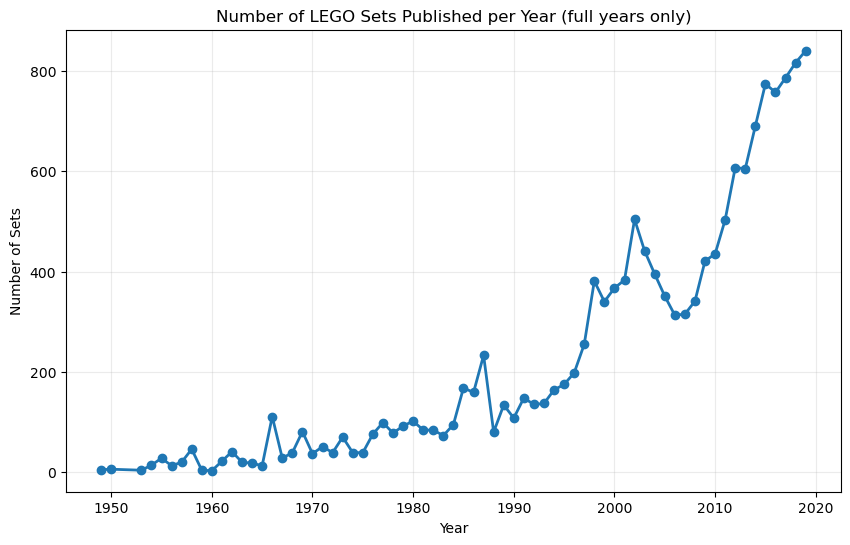

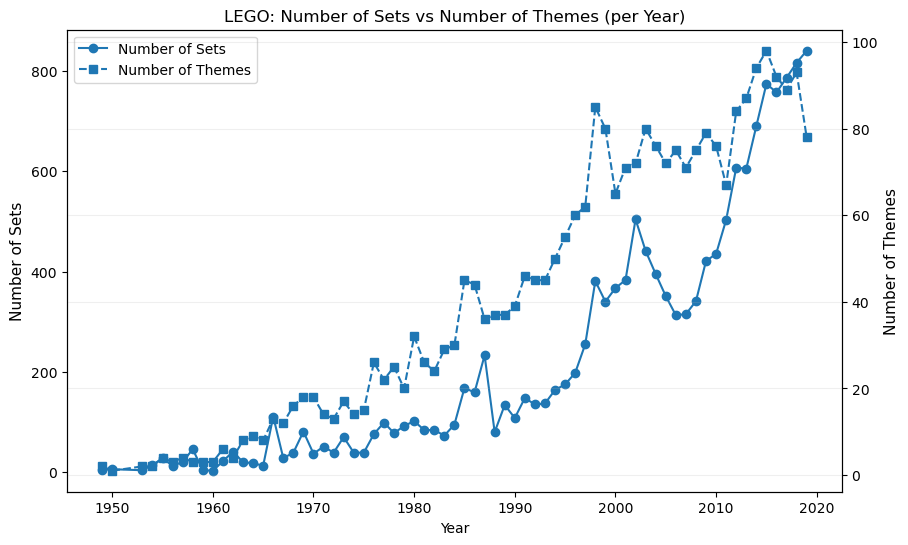

In [13]:
# Align indices: ensure both series include same years
common_years = sets_by_year.index.intersection(themes_by_year.index)

# Exclude last two potentially incomplete years from the shared view
years = common_years[:-2]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(years, sets_by_year.loc[years], marker='o', label='Number of Sets')
ax2.plot(years, themes_by_year.loc[years,'nr_themes'], marker='s', label='Number of Themes', linestyle='--')

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Sets', fontsize=11)
ax2.set_ylabel('Number of Themes', fontsize=11)

# Legends: combine both axis legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('LEGO: Number of Sets vs Number of Themes (per Year)')
plt.grid(alpha=0.2)
plt.show()

## Complexity: Average number of parts per set (per year)

**Why:** This helps us see if sets are getting more complex (on average) over time — an indicator of product complexity and customer targeting.

In [14]:
# Compute average parts per set per year
parts_per_set = sets.groupby('year').agg({'num_parts': 'mean'}).rename(columns={'num_parts':'avg_parts'}).sort_index()
display(parts_per_set.head(15))

# Scatter plot (exclude last two years if incomplete)
years_scatter = parts_per_set.index[:-2]
plt.figure()
plt.scatter(years_scatter, parts_per_set.loc[years_scatter,'avg_parts'])
plt.title('Average Number of Parts per LEGO Set (by Year)')
plt.xlabel('Year')
plt.ylabel('Average number of parts')
plt.grid(alpha=0.2)

,avg_parts
year,
1949,99.600000
1950,1.000000
1953,13.500000
1954,12.357143
1955,36.607143
1956,18.923077
1957,44.750000
1958,41.130435
1959,16.250000


## Themes: relational join & top themes by set count

**Why:** `sets.csv` references `theme_id`; `themes.csv` contains human-readable theme names. We'll:
1. Count sets per theme id.
2. Convert that into a DataFrame.
3. Merge with `themes` to get theme names.
4. Plot top 10 theme names by number of sets.

### Database schema (for reference)
<div style="text-align:center">
  <img src="https://i.imgur.com/Sg4lcjx.png" width="800" alt="database schema">
</div>

This image shows how `sets`, `themes`, `colors` link — `theme_id` in `sets` matches `id` in `themes`, etc.

In [16]:
# Count sets per theme_id
set_theme_count = sets['theme_id'].value_counts().rename_axis('id').reset_index(name='set_count')
set_theme_count.head()

# Merge with themes DataFrame (which should have columns 'id' and 'name')
merged_themes = pd.merge(set_theme_count, themes, on='id', how='left')

# Check for missing names (data quality check)
missing_names = merged_themes[merged_themes['name'].isnull()]
if len(missing_names) > 0:
    print("Warning: Some theme ids have no name mapping. Count:", len(missing_names))
else:
    print("All theme_id values mapped to theme names.")

# Show top 10 themes (by set_count)
top10_themes = merged_themes.sort_values('set_count', ascending=False).head(10)
display(top10_themes[['id','name','set_count']])

All theme_id values mapped to theme names.


,id,name,set_count
0,158,Star Wars,753
1,501,Gear,656
2,494,Friends,398
3,435,Ninjago,356
4,503,Key Chain,329
5,505,Basic Set,328
6,497,Books,310
7,632,Town,299
8,371,Supplemental,273
9,516,Duplo and Explore,248


### Plot Top 10 Themes by Number of Sets
A bar chart exposes which franchises or product categories LEGO focuses on most. We rotate labels to preserve readability.

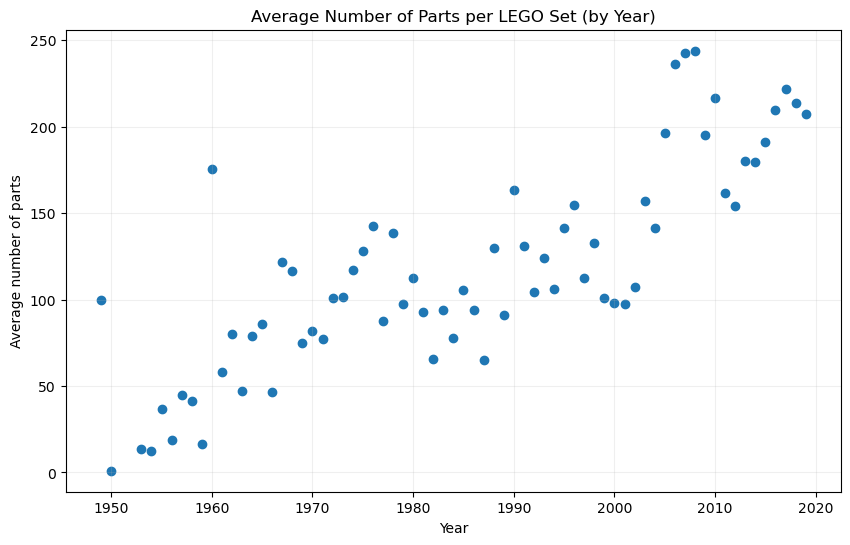

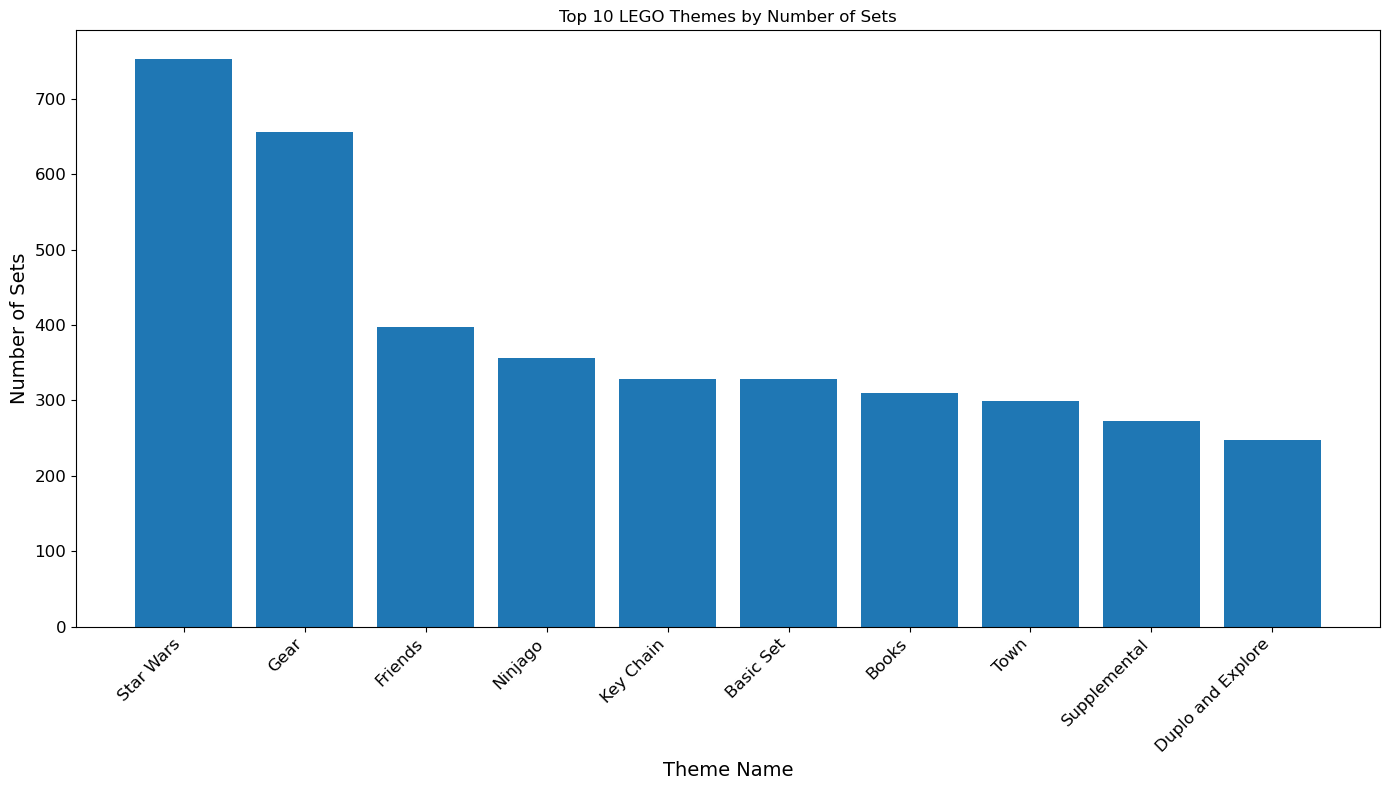

In [17]:
# Plotting top 10 themes
plt.figure(figsize=(14,8))
plt.bar(top10_themes['name'], top10_themes['set_count'])
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Theme Name', fontsize=14)
plt.ylabel('Number of Sets', fontsize=14)
plt.title('Top 10 LEGO Themes by Number of Sets')
plt.tight_layout()
plt.show()

## Star Wars deep dive

**Questions:**
- How many `id`s correspond to "Star Wars" in `themes.csv`? (Themes can have repeated names across different time ranges.)
- Which sets map to those Star Wars theme ids?

In [18]:
# Find rows in themes where name contains 'Star Wars' (case-insensitive)
star_wars_themes = themes[themes['name'].str.contains('Star Wars', case=False, na=False)]
display(star_wars_themes)

# Extract IDs and find sets matching those theme_ids
star_wars_ids = star_wars_themes['id'].unique().tolist()
print("Star Wars theme ids:", star_wars_ids)

# Filter sets that have those theme_ids
star_wars_sets = sets[sets['theme_id'].isin(star_wars_ids)].sort_values(['year','set_num'])
display(star_wars_sets[['set_num','name','year','num_parts','theme_id']].head(30))

,id,name,parent_id
17,18,Star Wars,1.0
150,158,Star Wars,NaN
174,209,Star Wars,207.0
211,261,Star Wars,258.0


Star Wars theme ids: [18, 158, 209, 261]


,set_num,name,year,num_parts,theme_id
10210,7101-1,Lightsaber Duel,1999,52,158
10555,7110-1,Landspeeder,1999,49,158
10557,7111-1,Droid Fighter,1999,62,158
10579,7121-1,Naboo Swamp,1999,82,158
10627,7128-1,Speeder Bikes,1999,93,158
10632,7130-1,Snowspeeder,1999,217,158
10643,7131-1,Anakin's Podracer,1999,136,158
10693,7140-1,X-wing Fighter,1999,271,158
10694,7141-1,Naboo Fighter,1999,179,158
10702,7150-1,TIE Fighter & Y-wing,1999,410,158


## Interpretation and Checks

### Interpretation tips
- Multiple `id`s for "Star Wars" indicate different sub-themes or reboots across time (e.g., original series, advent calendars, special product lines).
- Use the `year` column to see the lifecycle of each theme id (start-end years can often be inferred from earliest and latest set years).
- If you want, you can compute how many sets each Star Wars sub-theme produced and which sub-theme had most sets.



# Summary — Key Findings

- **Unique colours:** We quantified the distinct colour names (`.nunique()`), and separately computed transparency counts using two methods.
- **Origins:** The earliest LEGO sets in the dataset appear in **`{}`** (see cell where we computed min_year). [Run the cell above to see the exact year in your copy.]
- **Growth:** LEGO's production (number of sets/year) grew slowly in early decades, then accelerated — especially from the 1990s onward.
- **Complexity:** Average parts per set increased over time (the scatter plot shows an upward trend), suggesting modern sets are more complex.
- **Themes:** Merging `sets` and `themes` reveals which franchises/themes have most sets (e.g., Star Wars among top themes).

## Next steps & potential extensions (to make this project more *meaningful*)
1. **Time-series forecasting:** Forecast future number of sets or average parts per year using ARIMA or Prophet.
2. **Clustering themes:** Use set-level features (avg num_parts, price if available, year distribution) to cluster themes into product types.
3. **Interactive dashboard:** Use Plotly Dash or Streamlit for interactive exploration (filter by year, search theme names).
4. **Data quality & enrichment:** Deduplicate color names by RGB, enrich themes with external metadata (e.g., movie release dates for licensed themes).
5. **Sentiment / popularity tie-in:** Combine with sales/reviews or Bricklink resale values to study commercial success vs. set size/themes.

**Challenge**: How many different sets did LEGO sell in their first year? How many types of LEGO products were on offer in the year the company started?

In [23]:
sets[sets['year'] == 1949]

,set_num,name,year,theme_id,num_parts
9521,700.1-1,Extra-Large Gift Set (ABB),1949,365,142
9534,700.2-1,Large Gift Set (ABB),1949,365,178
9539,700.3-1,Medium Gift Set (ABB),1949,365,142
9544,700.A-1,Small Brick Set (ABB),1949,371,24
9545,700.B-1,Small Doors and Windows Set (ABB),1949,371,12


**Challenge**: Find the top 5 LEGO sets with the most number of parts. 

In [24]:
sets.sort_values('num_parts', ascending=False).head()

,set_num,name,year,theme_id,num_parts
15004,BIGBOX-1,The Ultimate Battle for Chima,2015,571,9987
11183,75192-1,UCS Millennium Falcon,2017,171,7541
10551,71043-1,Hogwarts Castle,2018,246,6020
295,10256-1,Taj Mahal,2017,673,5923
221,10189-1,Taj Mahal,2008,673,5922


**Challenge**: Use <code>.groupby()</code> and <code>.count()</code> to show the number of LEGO sets released year-on-year. How do the number of sets released in 1955 compare to the number of sets released in 2019? 

In [25]:
sets_by_year = sets.groupby('year').count()
sets_by_year['set_num'].head()

year
1949     5
1950     6
1953     4
1954    14
1955    28
Name: set_num, dtype: int64

In [26]:
sets_by_year['set_num'].tail()

year
2017    786
2018    816
2019    840
2020    674
2021      3
Name: set_num, dtype: int64

**Challenge**: Show the number of LEGO releases on a line chart using Matplotlib. <br>
<br>
Note that the .csv file is from late 2020, so to plot the full calendar years, you will have to exclude some data from your chart. Can you use the slicing techniques covered in Day 21 to avoid plotting the last two years? The same syntax will work on Pandas DataFrames. 

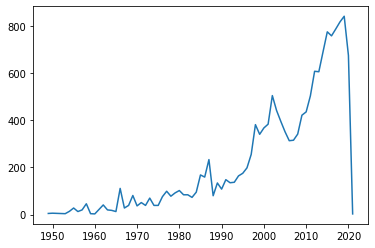

In [27]:
plt.plot(sets_by_year.index, sets_by_year.set_num)

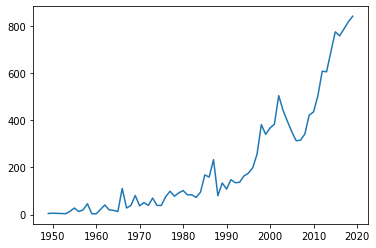

In [28]:
plt.plot(sets_by_year.index[:-2], sets_by_year.set_num[:-2])

### Aggregate Data with the Python .agg() Function

Let's work out the number of different themes shipped by year. This means we have to count the number of unique theme_ids per calendar year.

In [29]:
themes_by_year = sets.groupby('year').agg({'theme_id': pd.Series.nunique})

In [30]:
themes_by_year.rename(columns = {'theme_id':'nr_themes'}, inplace = True) 
themes_by_year.head()

,nr_themes
year,
1949,2
1950,1
1953,2
1954,2
1955,4


In [31]:
themes_by_year.tail()

,nr_themes
year,
2017,89
2018,93
2019,78
2020,82
2021,1


**Challenge**: Plot the number of themes released by year on a line chart. Only include the full calendar years (i.e., exclude 2020 and 2021). 

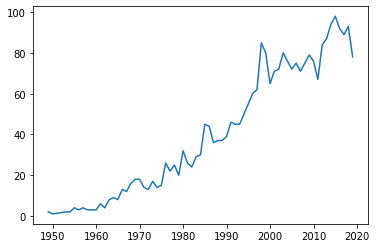

In [34]:
plt.plot(themes_by_year.index[:-2], themes_by_year.nr_themes[:-2])

### Line Charts with Two Seperate Axes

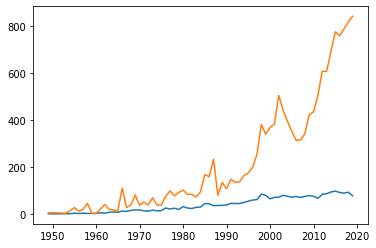

In [33]:
# This looks terrible
plt.plot(themes_by_year.index[:-2], themes_by_year.nr_themes[:-2])
plt.plot(sets_by_year.index[:-2], sets_by_year.set_num[:-2])

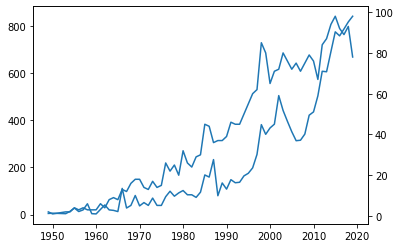

In [38]:
ax1 = plt.gca() # get the axis
ax2 = ax1.twinx() # create another axis that shares the same x-axis

ax1.plot(sets_by_year.index[:-2], sets_by_year.set_num[:-2])
ax2.plot(themes_by_year.index[:-2], themes_by_year.nr_themes[:-2])

Text(0, 0.5, 'Number of Themes')

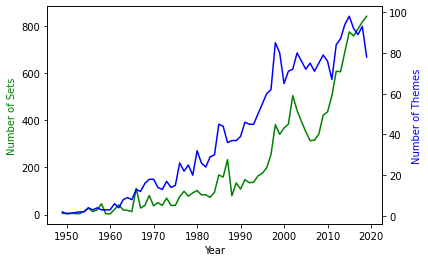

In [41]:
ax1 = plt.gca()
ax2 = ax1.twinx()

# Add styling
ax1.plot(sets_by_year.index[:-2], sets_by_year.set_num[:-2], color='g')
ax2.plot(themes_by_year.index[:-2], themes_by_year.nr_themes[:-2], 'b')

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Sets', color='green')
ax2.set_ylabel('Number of Themes', color='blue')

**Challenge**: Use the <code>.groupby()</code> and <code>.agg()</code> function together to figure out the average number of parts per set. How many parts did the average LEGO set released in 1954 compared to say, 2017?

In [42]:
parts_per_set = sets.groupby('year').agg({'num_parts': pd.Series.mean})
parts_per_set.head()

,num_parts
year,
1949,99.600000
1950,1.000000
1953,13.500000
1954,12.357143
1955,36.607143


In [43]:
parts_per_set.tail()

,num_parts
year,
2017,221.840967
2018,213.618873
2019,207.510714
2020,259.732938
2021,0.000000


### Scatter Plots in Matplotlib

**Challenge**: Has the size and complexity of LEGO sets increased over time based on the number of parts? Plot the average number of parts over time using a Matplotlib scatter plot. See if you can use the [scatter plot documentation](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.scatter.html) before I show you the solution. Do you spot a trend in the chart? 

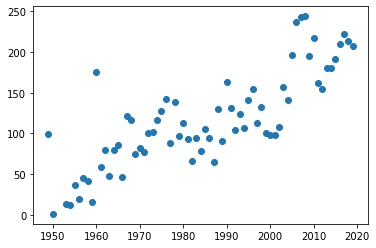

In [44]:
plt.scatter(parts_per_set.index[:-2], parts_per_set.num_parts[:-2])

### Number of Sets per LEGO Theme

LEGO has licensed many hit franchises from Harry Potter to Marvel Super Heros to many others. But which theme has the largest number of individual sets? Is it one of LEGO's own themes like Ninjago or Technic or is it a third party theme? Let's analyse LEGO's product lines!

In [45]:
set_theme_count = sets["theme_id"].value_counts()
set_theme_count[:5]

158    753
501    656
494    398
435    356
503    329
Name: theme_id, dtype: int64

**Challenge** Use what you know about HTML markup and tags to display the database schema: https://i.imgur.com/Sg4lcjx.png

<img src="https://i.imgur.com/Sg4lcjx.png">

### Database Schemas, Foreign Keys and Merging DataFrames

The themes.csv file has the actual theme names. The sets .csv has <code>theme_ids</code> which link to the <code>id</code> column in the themes.csv.

**Challenge**: Explore the themes.csv. How is it structured? Search for the name 'Star Wars'. How many <code>id</code>s correspond to this name in the themes.csv? Now use these <code>id</code>s and find the corresponding the sets in the sets.csv (Hint: you'll need to look for matches in the <code>theme_id</code> column)

In [46]:
themes = pd.read_csv('data/themes.csv') # has the theme names!
themes.head()

,id,name,parent_id
0,1,Technic,NaN
1,2,Arctic Technic,1.0
2,3,Competition,1.0
3,4,Expert Builder,1.0
4,5,Model,1.0


In [47]:
themes[themes.name == 'Star Wars']

,id,name,parent_id
17,18,Star Wars,1.0
150,158,Star Wars,NaN
174,209,Star Wars,207.0
211,261,Star Wars,258.0


In [48]:
sets[sets.theme_id == 18]

,set_num,name,year,theme_id,num_parts
8786,65081-1,R2-D2 / C-3PO Droid Collectors Set,2002,18,1
12051,8000-1,Pit Droid,2000,18,223
12058,8001-1,Battle Droid,2000,18,336
12066,8002-1,Destroyer Droid,2000,18,567
12071,8007-1,C-3PO,2001,18,339
12072,8008-1,Stormtrooper,2001,18,360
12073,8009-1,R2-D2,2002,18,239
12074,8010-1,Darth Vader,2002,18,388
12081,8011-1,Jango Fett,2002,18,425
12083,8012-1,Super Battle Droid,2002,18,378


In [49]:
sets[sets.theme_id == 209]

,set_num,name,year,theme_id,num_parts
11013,75023-1,Star Wars Advent Calendar 2013,2013,209,254
11046,75056-1,Star Wars Advent Calendar 2014,2014,209,273
11080,75097-1,Star Wars Advent Calendar 2015,2015,209,291
11131,75146-1,Star Wars Advent Calendar 2016,2016,209,282
11173,75184-1,Star Wars Advent Calendar 2017,2017,209,309
11206,75213-1,Star Wars Advent Calendar 2018,2018,209,307
11245,75245-1,Star Wars Advent Calendar 2019,2019,209,280
11281,75279-1,Star Wars Advent Calendar 2020,2020,209,312
12019,7958-1,Star Wars Advent Calendar 2011,2011,209,267
14352,9509-1,Star Wars Advent Calendar 2012,2012,209,235


### Merging (i.e., Combining) DataFrames based on a Key


In [50]:
set_theme_count = pd.DataFrame({'id':set_theme_count.index, 
                                'set_count':set_theme_count.values})
set_theme_count.head()

,id,set_count
0,158,753
1,501,656
2,494,398
3,435,356
4,503,329


In [51]:
merged_df = pd.merge(set_theme_count, themes, on='id')
merged_df[:3]

,id,set_count,name,parent_id
0,158,753,Star Wars,NaN
1,501,656,Gear,NaN
2,494,398,Friends,NaN


<BarContainer object of 10 artists>

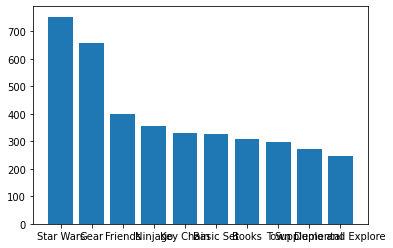

In [52]:
# Basic, but unreadable
plt.bar(merged_df.name[:10], merged_df.set_count[:10])

<BarContainer object of 10 artists>

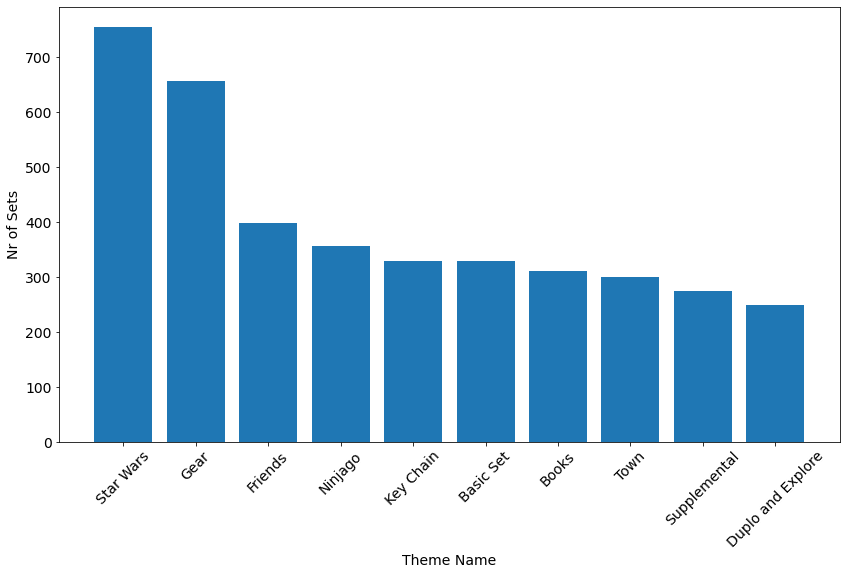

In [53]:
plt.figure(figsize=(14,8))
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.ylabel('Nr of Sets', fontsize=14)
plt.xlabel('Theme Name', fontsize=14)

plt.bar(merged_df.name[:10], merged_df.set_count[:10])

